In [20]:
%pip install hdbscan numpy pandas matplotlib seaborn scikit-learn

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\Phili\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import hdbscan
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import QuantileTransformer
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Preprocess the data

In [22]:
# Load data
data = pd.read_csv('new5.txt', delimiter=',', header=None)

# Remove uneeded columns
columns_to_drop = [6,7,9,10] 
data = data.drop(data.columns[columns_to_drop], axis=1)

header_names = ['', 'Frame number', 'Index number', 'x_coordinate', 'y_coordinate', 'z_coordinate', 'doppler_bin', 'SNR' , 'noise','timestamp']
data.columns = header_names

print(data.head())
print(data.columns)

              Frame number  Index number  x_coordinate  y_coordinate  \
0  ti_mmwave             0             0      0.010613      0.042265   
1  ti_mmwave             0             1      0.041824     -0.006817   
2  ti_mmwave             0             2      0.875838     -0.035448   
3  ti_mmwave             0             3      0.429856      0.460828   
4  ti_mmwave             0             4      4.373080      4.229256   

   z_coordinate  doppler_bin    SNR  noise     timestamp  
0      0.002115          8.0  858.0  608.0  2.025031e+13  
1      0.010379          8.0  858.0  608.0  2.025031e+13  
2     -0.719994          8.0  712.0  543.0  2.025031e+13  
3     -0.943187          8.0  712.0  543.0  2.025031e+13  
4     -0.912308          8.0  690.0  570.0  2.025031e+13  
Index(['', 'Frame number', 'Index number', 'x_coordinate', 'y_coordinate',
       'z_coordinate', 'doppler_bin', 'SNR', 'noise', 'timestamp'],
      dtype='object')


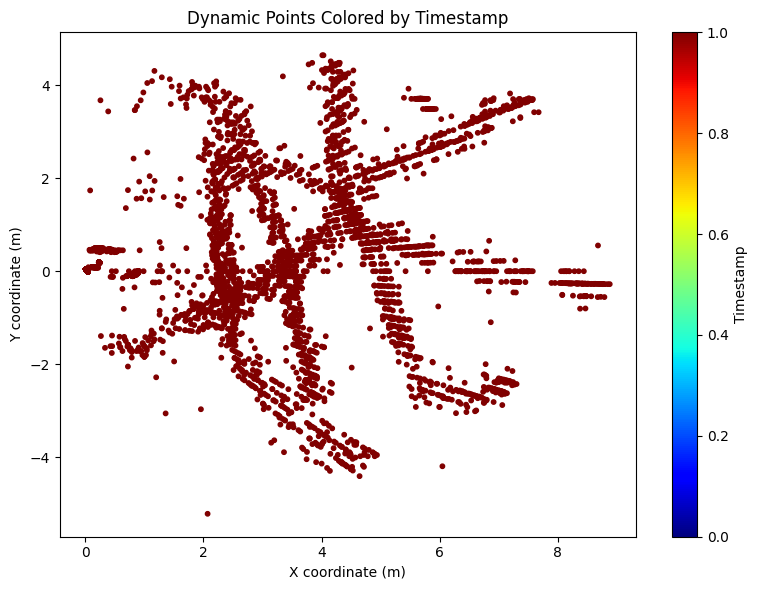

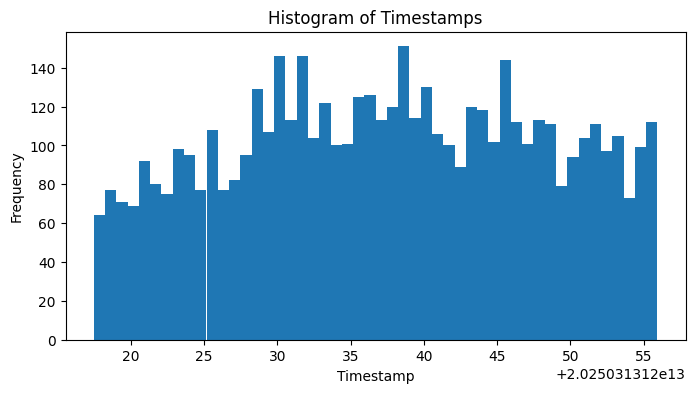

In [23]:
norm = mcolors.Normalize(vmin=0, vmax=1)
plt.figure(figsize=(8, 6))
plt.scatter(data['x_coordinate'], data['y_coordinate'],
            c=data['timestamp'], cmap='jet', norm=norm, s=10)
plt.xlabel("X coordinate (m)")
plt.ylabel("Y coordinate (m)")
plt.title("Dynamic Points Colored by Timestamp")
cbar = plt.colorbar()
cbar.set_label("Timestamp")
plt.tight_layout()
plt.show()


plt.figure(figsize=(8,4))
plt.hist(data['timestamp'], bins=50)
plt.xlabel("Timestamp")
plt.ylabel("Frequency")
plt.title("Histogram of Timestamps")
plt.show()


Doppler filtering

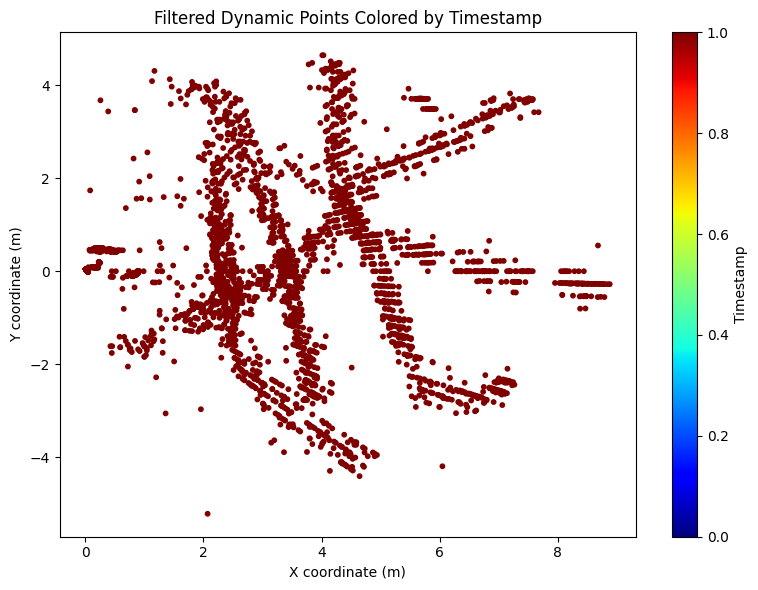

In [24]:
threshold = 6

df_filtered = data[data['doppler_bin'] > threshold].copy()

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(df_filtered['x_coordinate'], df_filtered['y_coordinate'],
            c=df_filtered['timestamp'], cmap='jet', norm=norm, s=10)
plt.xlabel("X coordinate (m)")
plt.ylabel("Y coordinate (m)")
plt.title("Filtered Dynamic Points Colored by Timestamp")
cbar = plt.colorbar()
cbar.set_label("Timestamp")
plt.tight_layout()
plt.show()

Removal of static objects

In [25]:
def remove_static_objects_df(data, x_edges, y_edges, tau):
    frames = []
    indices_per_frame = []
    for frame_num, group in data.groupby('Frame number'):
        pts = group[['x_coordinate', 'y_coordinate']].values
        frames.append(pts)
        indices_per_frame.append(group.index)
    
    density = np.zeros((len(x_edges) - 1, len(y_edges) - 1))
    for pts in frames:
        hist, _, _ = np.histogram2d(pts[:, 0], pts[:, 1], bins=[x_edges, y_edges])
        hist = (hist > 0).astype(int)
        density += hist
        
    static_bins = density > tau
    
    dynamic_idx = []
    static_idx = []
    for pts, idx in zip(frames, indices_per_frame):
        bin_x = np.digitize(pts[:, 0], x_edges) - 1
        bin_y = np.digitize(pts[:, 1], y_edges) - 1
        dynamic_mask = []
        static_mask = []
        for bx, by in zip(bin_x, bin_y):
            if bx < 0 or bx >= static_bins.shape[0] or by < 0 or by >= static_bins.shape[1]:
                dynamic_mask.append(True)
                static_mask.append(False)
            else:
                if static_bins[bx, by]:
                    dynamic_mask.append(False)
                    static_mask.append(True)
                else:
                    dynamic_mask.append(True)
                    static_mask.append(False)
        dynamic_mask = np.array(dynamic_mask)
        static_mask = np.array(static_mask)
        dynamic_idx.extend(idx[dynamic_mask])
        static_idx.extend(idx[static_mask])
    
    dynamic_data = data.loc[dynamic_idx].copy()
    static_data = data.loc[static_idx].copy()
    return dynamic_data, static_data


In [26]:
x_min, x_max = data['x_coordinate'].min(), data['x_coordinate'].max()
y_min, y_max = data['y_coordinate'].min(), data['y_coordinate'].max()
num_bins = 40
x_edges = np.linspace(x_min, x_max, num_bins + 1)
y_edges = np.linspace(y_min, y_max, num_bins + 1)

T = data['Frame number'].nunique()
tau = 0.1 * T 

dynamic_data, static_data = remove_static_objects_df(data, x_edges, y_edges, tau)

Visualize

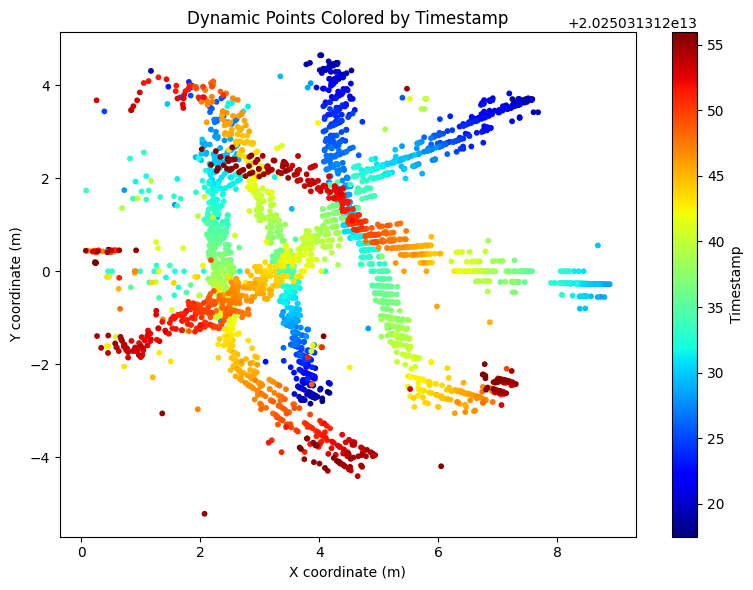

Total dynamic points: 3347
Total static points removed: 1850


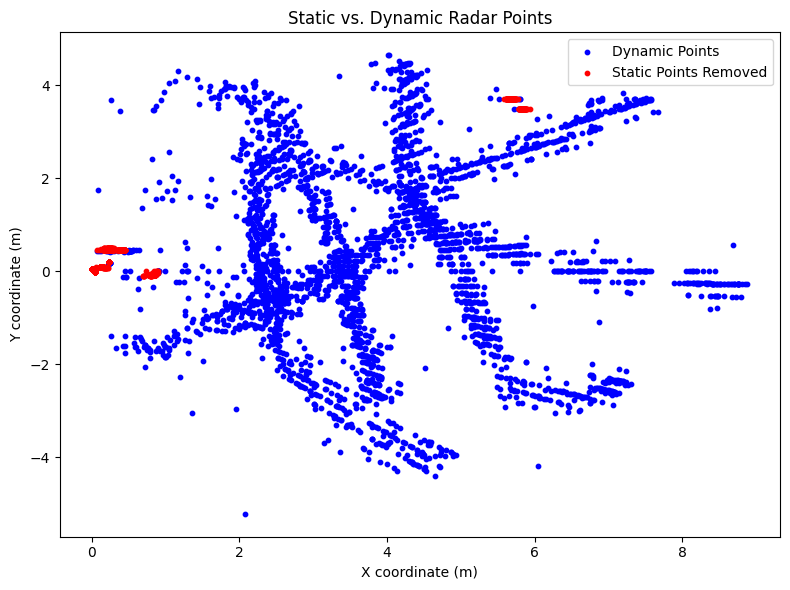

In [27]:
timestamps_dynamic = dynamic_data['timestamp'].values

norm = mcolors.Normalize(vmin=timestamps_dynamic.min(), vmax=timestamps_dynamic.max())

plt.figure(figsize=(8, 6))
plt.scatter(dynamic_data['x_coordinate'], dynamic_data['y_coordinate'],
            c=timestamps_dynamic, cmap='jet', norm=norm, s=10)
plt.xlabel("X coordinate (m)")
plt.ylabel("Y coordinate (m)")
plt.title("Dynamic Points Colored by Timestamp")
cbar = plt.colorbar()
cbar.set_label("Timestamp")
plt.tight_layout()
plt.show()

print("Total dynamic points:", dynamic_data.shape[0])
print("Total static points removed:", static_data.shape[0])

plt.figure(figsize=(8, 6))
plt.scatter(dynamic_data['x_coordinate'], dynamic_data['y_coordinate'],
            c='blue', s=10, label='Dynamic Points')
plt.scatter(static_data['x_coordinate'], static_data['y_coordinate'],
            c='red', s=10, label='Static Points Removed')
plt.xlabel("X coordinate (m)")
plt.ylabel("Y coordinate (m)")
plt.title("Static vs. Dynamic Radar Points")
plt.legend()
plt.tight_layout()
plt.show()

Noise reduction

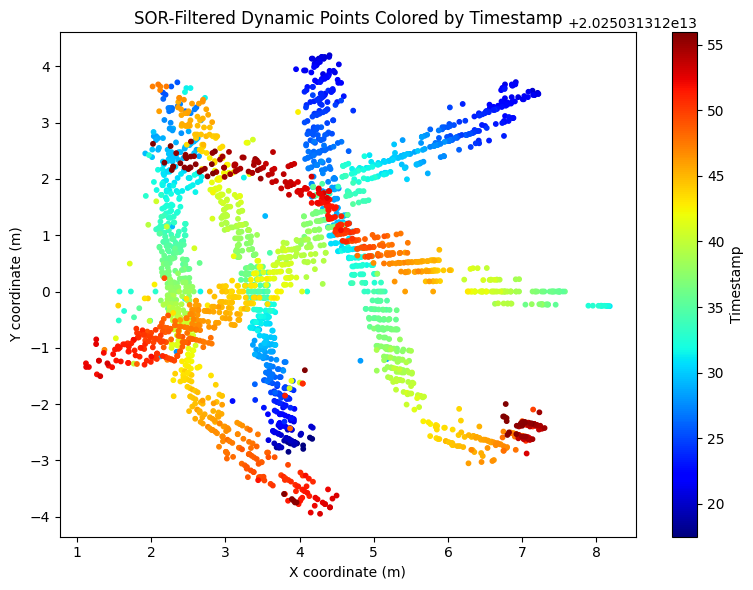

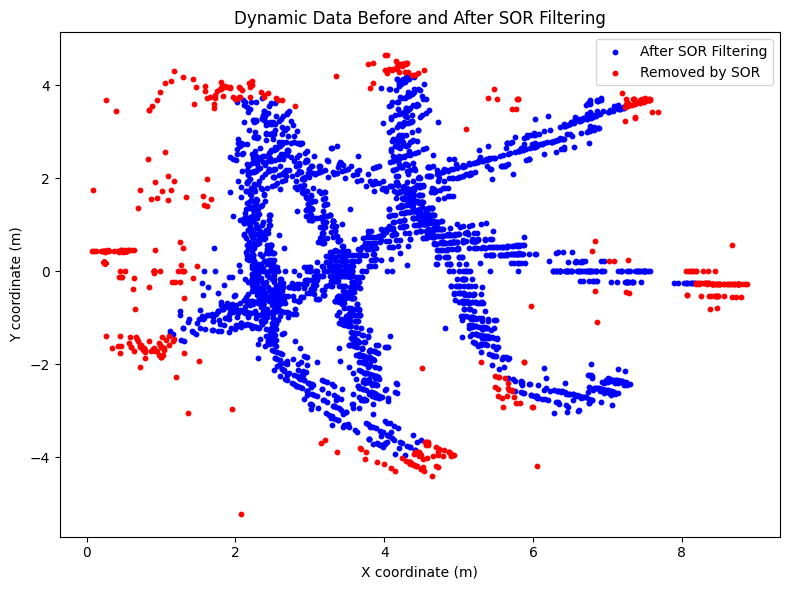

In [28]:
from sklearn.neighbors import NearestNeighbors
def remove_noise_statistical_df(data, x_col='x_coordinate', y_col='y_coordinate', k=8, std_ratio=1.0):
    points = data[[x_col, y_col]].values
    nbrs = NearestNeighbors(n_neighbors=k+1).fit(points)
    distances, _ = nbrs.kneighbors(points)
    avg_distances = np.mean(distances[:, 1:], axis=1)
    mean_dist = np.mean(avg_distances)
    std_dist = np.std(avg_distances)
    threshold = mean_dist + std_ratio * std_dist
    noise_mask = avg_distances < threshold
    filtered_data = data[noise_mask].copy()
    return filtered_data, noise_mask

k_val = int(len(dynamic_data) * 0.05)
filtered_data, noise_mask = remove_noise_statistical_df(dynamic_data, k=k_val, std_ratio=1)

timestamps_filtered = filtered_data['timestamp'].values


norm = mcolors.Normalize(vmin=timestamps_filtered.min(), vmax=timestamps_filtered.max())

plt.figure(figsize=(8, 6))
plt.scatter(filtered_data['x_coordinate'], filtered_data['y_coordinate'],
            c=timestamps_filtered, cmap='jet', norm=norm, s=10)
plt.xlabel("X coordinate (m)")
plt.ylabel("Y coordinate (m)")
plt.title("SOR-Filtered Dynamic Points Colored by Timestamp")
cbar = plt.colorbar()
cbar.set_label("Timestamp")
plt.tight_layout()
plt.show()

removed_data = dynamic_data.loc[~dynamic_data.index.isin(filtered_data.index)]

plt.figure(figsize=(8, 6))
plt.scatter(filtered_data['x_coordinate'], filtered_data['y_coordinate'], c='blue', s=10, label='After SOR Filtering')
plt.scatter(removed_data['x_coordinate'], removed_data['y_coordinate'], c='red', s=10, label='Removed by SOR')
plt.xlabel("X coordinate (m)")
plt.ylabel("Y coordinate (m)")
plt.title("Dynamic Data Before and After SOR Filtering")
plt.legend()
plt.tight_layout()
plt.show()



SNR Noise removal

SNR threshold for filtering: 6
Noise threshold for filtering: 597.0


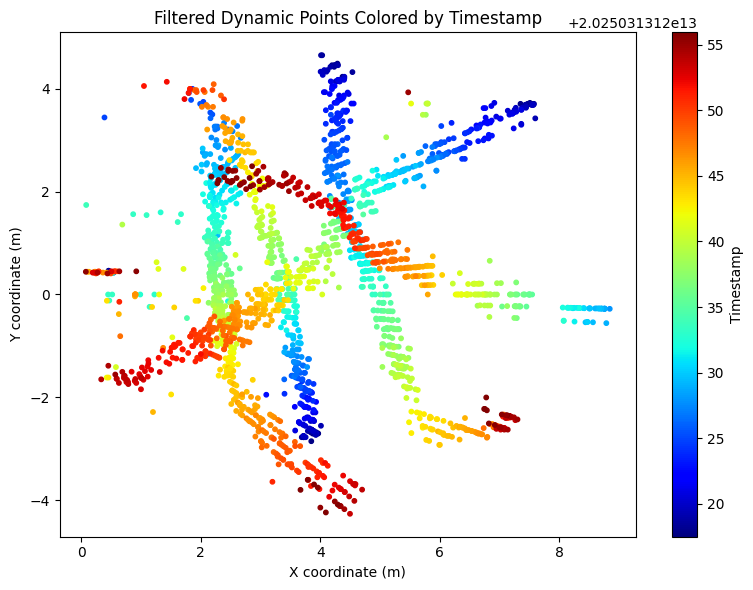

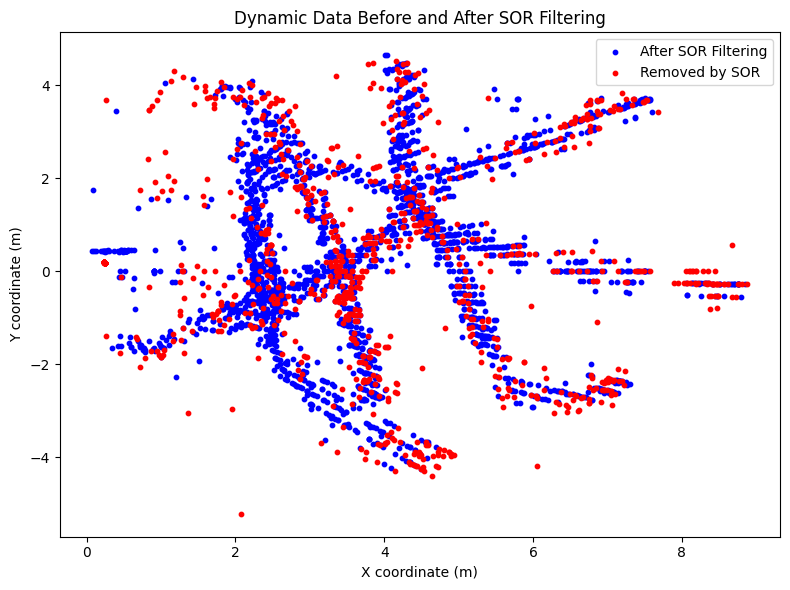

In [29]:
SNR_threshold = np.quantile(filtered_data['SNR'], 0.15)
print("SNR threshold for filtering:", threshold)
noise_threshold = np.quantile(filtered_data['noise'], 0.90)
print("Noise threshold for filtering:", noise_threshold)

df_filtered = dynamic_data[(dynamic_data['SNR'] >= SNR_threshold) &
                 (dynamic_data['noise'] <= noise_threshold)].copy()

# Plot  
plt.figure(figsize=(8, 6))
plt.scatter(df_filtered['x_coordinate'], df_filtered['y_coordinate'],
            c=df_filtered['timestamp'], cmap='jet', norm=norm, s=10)
plt.xlabel("X coordinate (m)")
plt.ylabel("Y coordinate (m)")
plt.title("Filtered Dynamic Points Colored by Timestamp")
cbar = plt.colorbar()
cbar.set_label("Timestamp")
plt.tight_layout()
plt.show()


removed_data2 = dynamic_data.loc[~dynamic_data.index.isin(df_filtered.index)]

plt.figure(figsize=(8, 6))
plt.scatter(df_filtered['x_coordinate'], df_filtered['y_coordinate'], c='blue', s=10, label='After SOR Filtering')
plt.scatter(removed_data2['x_coordinate'], removed_data2['y_coordinate'], c='red', s=10, label='Removed by SOR')
plt.xlabel("X coordinate (m)")
plt.ylabel("Y coordinate (m)")
plt.title("Dynamic Data Before and After SOR Filtering")
plt.legend()
plt.tight_layout()
plt.show()

HDBSCAN

Number of clusters (people): 5


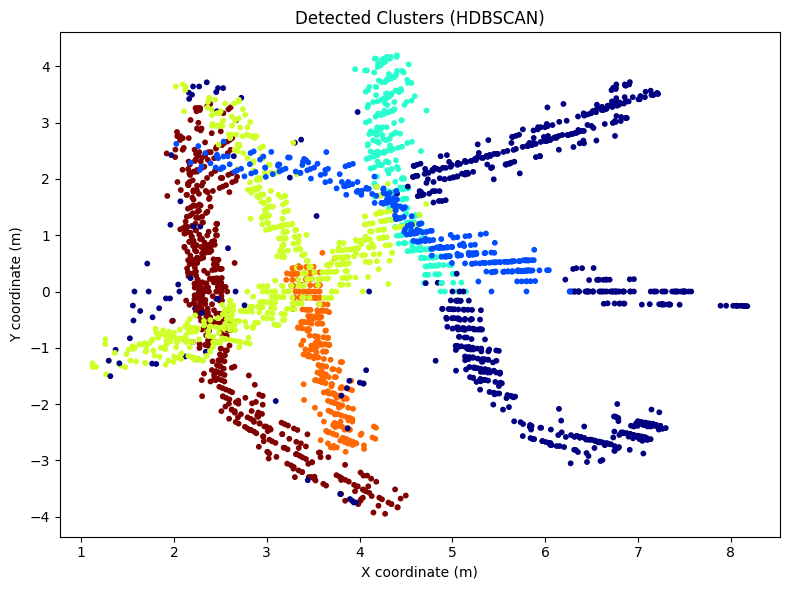

In [30]:
# change alpha and beta to adjust the distance metric
# alpha: weight for the time component 
# beta: weight for the angle component
def distance(a, b, alpha=1):
    spatial = np.sqrt((a[0] - b[0])**2 + (a[1] - b[1])**2)
    
    temporal = abs(a[2] - b[2])
    
    return np.sqrt(spatial**2 + (alpha * temporal)**2)

alpha_time = 0.5  # scales the timestamp component

points_3d = np.column_stack((filtered_data['x_coordinate'].values,
                            filtered_data['y_coordinate'].values,
                            filtered_data['timestamp'].values))

scaler = StandardScaler()
points_3d_scaled = scaler.fit_transform(points_3d)

c_size = int(len(points_3d_scaled) * 0.1)
clusterer = hdbscan.HDBSCAN(min_cluster_size=c_size, min_samples=4, metric=distance, cluster_selection_epsilon=0.1, cluster_selection_method='eom')
cluster_labels = clusterer.fit_predict(points_3d_scaled)

num_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
print("Number of clusters (people):", num_clusters)

plt.figure(figsize=(8, 6))
plt.scatter(filtered_data['x_coordinate'], filtered_data['y_coordinate'], 
            c=cluster_labels, cmap='jet', s=10)
plt.xlabel("X coordinate (m)")
plt.ylabel("Y coordinate (m)")
plt.title("Detected Clusters (HDBSCAN)")
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import hdbscan
import time
from IPython.display import display, clear_output

# --- Assumptions & Preparations ---
# filtered_data: your SOR-filtered DataFrame with at least:
#   'Frame number', 'x_coordinate', 'y_coordinate'
# Ensure it’s sorted chronologically:
filtered_data = filtered_data.sort_values('Frame number')

unique_frames = sorted(filtered_data['Frame number'].unique())

# Prepare a DataFrame to accumulate all frames’ assignments
global_data = filtered_data.iloc[0:0].copy()
global_data['cluster'] = pd.Series(dtype=int)

# Storage for global clusters: id → {centroid: [x,y], count: N}
global_clusters = {}
next_global_id = 0

# A distance threshold (in meters) for associating local clusters to global ones
distance_threshold = 1.0

plt.ioff()  # we'll manage display manually

for frame in unique_frames:
    # 1) extract and cluster this frame locally
    frame_df = filtered_data[filtered_data['Frame number']==frame].copy()
    pts = frame_df[['x_coordinate','y_coordinate']].values
    
    if len(pts) > 1:
        # cluster this frame’s points using only spatial distances
        local_clusterer = hdbscan.HDBSCAN(
            min_cluster_size=3, min_samples=1,
            metric='euclidian', cluster_selection_method='eom'
        )
        local_labels = local_clusterer.fit_predict(pts)
    else:
        local_labels = np.array([-1]*len(pts))
    
    frame_df['local_label'] = local_labels
    
    # 2) for each local cluster, compute its centroid
    local_centroids = {}
    for lab in np.unique(local_labels):
        if lab == -1:
            continue
        members = pts[local_labels==lab]
        local_centroids[lab] = members.mean(axis=0)
    
    # 3) assign a global ID to each local cluster
    lab_to_global = {}
    for lab, cent in local_centroids.items():
        # find best matching global cluster
        best_id, best_dist = None, np.inf
        for gid, info in global_clusters.items():
            d = np.linalg.norm(cent - info['centroid'])
            if d < best_dist:
                best_dist, best_id = d, gid
        
        if best_dist < distance_threshold:
            # match to existing
            lab_to_global[lab] = best_id
            # update centroid by running average
            old_cent, count = global_clusters[best_id]['centroid'], global_clusters[best_id]['count']
            new_cent = (old_cent*count + cent)/(count+1)
            global_clusters[best_id] = {'centroid': new_cent, 'count': count+1}
        else:
            # create new global cluster
            lab_to_global[lab] = next_global_id
            global_clusters[next_global_id] = {'centroid': cent.copy(), 'count': 1}
            next_global_id += 1
    
    # 4) map local labels → global, noise remains -1
    frame_df['cluster'] = frame_df['local_label'].map(lab_to_global).fillna(-1).astype(int)
    frame_df = frame_df.drop(columns='local_label')
    
    # 5) append to global_data
    global_data = pd.concat([global_data, frame_df], ignore_index=True)
    
    # --- dynamic inline plotting ---
    fig, ax = plt.subplots(figsize=(8, 6))
    sc = ax.scatter(global_data['x_coordinate'], global_data['y_coordinate'],
                    c=global_data['cluster'], cmap='jet', s=10)
    ax.set_title(f"Incremental Clustering Through Frame {frame}")
    ax.set_xlabel("X (m)")
    ax.set_ylabel("Y (m)")
    cbar = plt.colorbar(sc, ax=ax)
    cbar.set_label("Global Cluster ID")
    
    display(fig)
    clear_output(wait=True)
    plt.close(fig)
    time.sleep(0.5)

# final display
plt.figure(figsize=(8,6))
plt.scatter(global_data['x_coordinate'], global_data['y_coordinate'],
            c=global_data['cluster'], cmap='jet', s=10)
plt.title("Final Incremental Clustering")
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.colorbar(label="Global Cluster ID")
plt.tight_layout()
plt.show()


IndexError: index 2 is out of bounds for axis 0 with size 2